Imports

In [ ]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Kalman Filter


Step 0:
True Position: 0.00, 0.00, 5000.00
Estimated Position: -0.08, 0.10, 4999.87
Position Error: 0.18 meters

Step 1:
True Position: 0.20, 0.15, 4999.95
Estimated Position: 0.08, 0.23, 4999.87
Position Error: 0.16 meters

Step 2:
True Position: 0.40, 0.30, 4999.90
Estimated Position: 0.33, 0.35, 4999.89
Position Error: 0.08 meters

Step 3:
True Position: 0.60, 0.45, 4999.85
Estimated Position: 0.67, 0.45, 4999.77
Position Error: 0.10 meters

Step 4:
True Position: 0.80, 0.60, 4999.80
Estimated Position: 0.86, 0.68, 4999.80
Position Error: 0.10 meters

Step 5:
True Position: 1.00, 0.75, 4999.75
Estimated Position: 1.02, 0.76, 4999.69
Position Error: 0.06 meters

Step 6:
True Position: 1.20, 0.90, 4999.70
Estimated Position: 1.16, 0.84, 4999.62
Position Error: 0.11 meters

Step 7:
True Position: 1.40, 1.05, 4999.65
Estimated Position: 1.37, 1.03, 4999.60
Position Error: 0.06 meters

Step 8:
True Position: 1.60, 1.20, 4999.60
Estimated Position: 1.58, 1.16, 4999.62
Position Error: 0.0

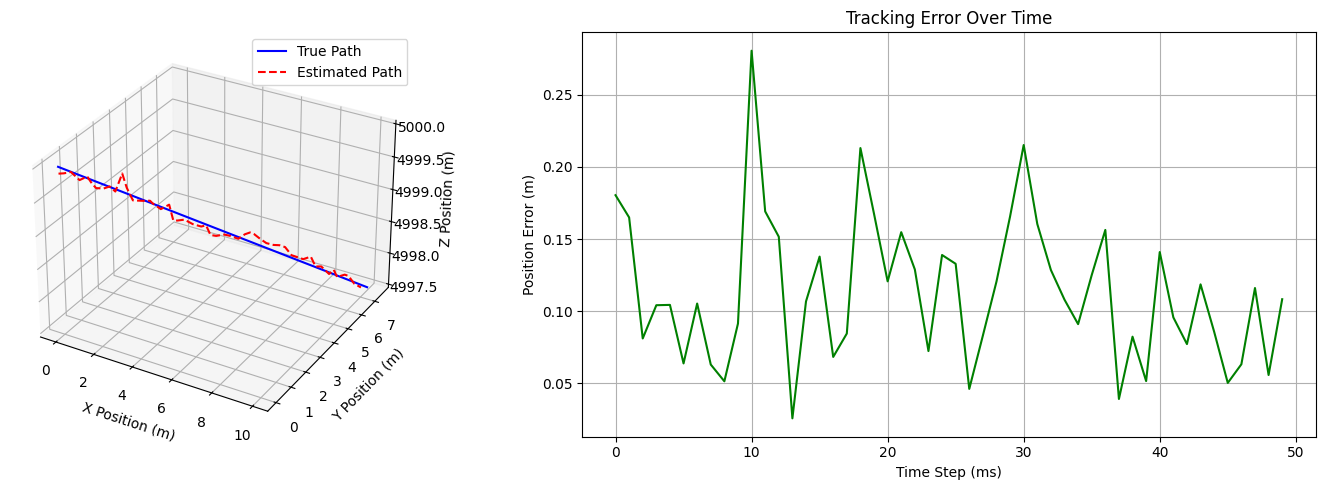

In [29]:
@dataclass
class Vector3D:
    x: float
    y: float
    z: float

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def norm(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

class MissileTracker:
    def __init__(self, measurement_interval):
        self.dt = 0.001
        self.T = measurement_interval
        self.x = np.zeros(6)
        self.F = np.eye(6)
        self.F[3:, :3] = np.eye(3) * self.dt
        self.B = np.zeros((6, 3))
        self.B[:3, :] = np.eye(3) * self.dt
        self.B[3:, :] = np.eye(3) * 0.5 * self.dt**2
        self.H = np.eye(6)
        self.P = np.eye(6) * 0.1
        self.Q = np.eye(6) * 0.01
        self.R = np.eye(6)

    def predict(self, acceleration):
        u = np.array([acceleration.x, acceleration.y, acceleration.z])
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, measurement):
        y = measurement - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(6) - K @ self.H) @ self.P

    def get_position(self):
        return Vector3D(self.x[3], self.x[4], self.x[5])

    def get_velocity(self):
        return Vector3D(self.x[0], self.x[1], self.x[2])

def simulate_target(initial_state, steps, acceleration_func):
    state = initial_state.copy()
    states = [state.copy()]

    for t in range(steps):
        a = acceleration_func(t)
        state[:3] += np.array([a.x, a.y, a.z]) * 0.001
        state[3:] += state[:3] * 0.001
        states.append(state.copy())

    return np.array(states)

def main():
    TOTAL_STEPS = 50
    MEASUREMENT_INTERVAL = 1
    NOISE_STD = 0.1

    tracker = MissileTracker(MEASUREMENT_INTERVAL)

    initial_state = np.array([
        200.0, 150.0, -50.0,
        0.0, 0.0, 5000.0
    ])

    def get_acceleration(t):
        return Vector3D(
            0.5 * np.sin(t * 0.1),
            0.3 * np.cos(t * 0.1),
            -0.2
        )

    true_states = simulate_target(initial_state, TOTAL_STEPS, get_acceleration)

    tracker.x = initial_state
    tracker.R = np.eye(6) * NOISE_STD**2

    estimated_positions = []
    position_errors = []

    for step in range(TOTAL_STEPS):
        true_state = true_states[step]
        a = get_acceleration(step)
        tracker.predict(a)

        if step % MEASUREMENT_INTERVAL == 0:
            measurement = true_state + np.random.normal(0, NOISE_STD, 6)
            tracker.update(measurement)

        est_pos = tracker.get_position()
        true_pos = Vector3D(true_state[3], true_state[4], true_state[5])
        error = (est_pos - true_pos).norm()

        estimated_positions.append([est_pos.x, est_pos.y, est_pos.z])
        position_errors.append(error)

        print(f"\nStep {step}:")
        print(f"True Position: {true_pos.x:.2f}, {true_pos.y:.2f}, {true_pos.z:.2f}")
        print(f"Estimated Position: {est_pos.x:.2f}, {est_pos.y:.2f}, {est_pos.z:.2f}")
        print(f"Position Error: {error:.2f} meters")

    print(f"\nAverage Position Error: {np.mean(position_errors):.2f} meters")
    print(f"Max Position Error: {np.max(position_errors):.2f} meters")

    plot_results(true_states, np.array(estimated_positions), position_errors)

def plot_results(true_states, estimated_positions, errors):
    time_steps = np.arange(len(errors))

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(true_states[:, 3], true_states[:, 4], true_states[:, 5], 'b-', label='True Path')
    ax.plot(estimated_positions[:, 0], estimated_positions[:, 1], estimated_positions[:, 2],
            'r--', label='Estimated Path')
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Z Position (m)')
    ax.legend()

    plt.subplot(122)
    plt.plot(time_steps, errors, 'g-')
    plt.xlabel('Time Step (ms)')
    plt.ylabel('Position Error (m)')
    plt.title('Tracking Error Over Time')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


##Experiments

Experiment with different levels of Noise:


Average Position Error: 0.01 meters
Max Position Error: 0.06 meters


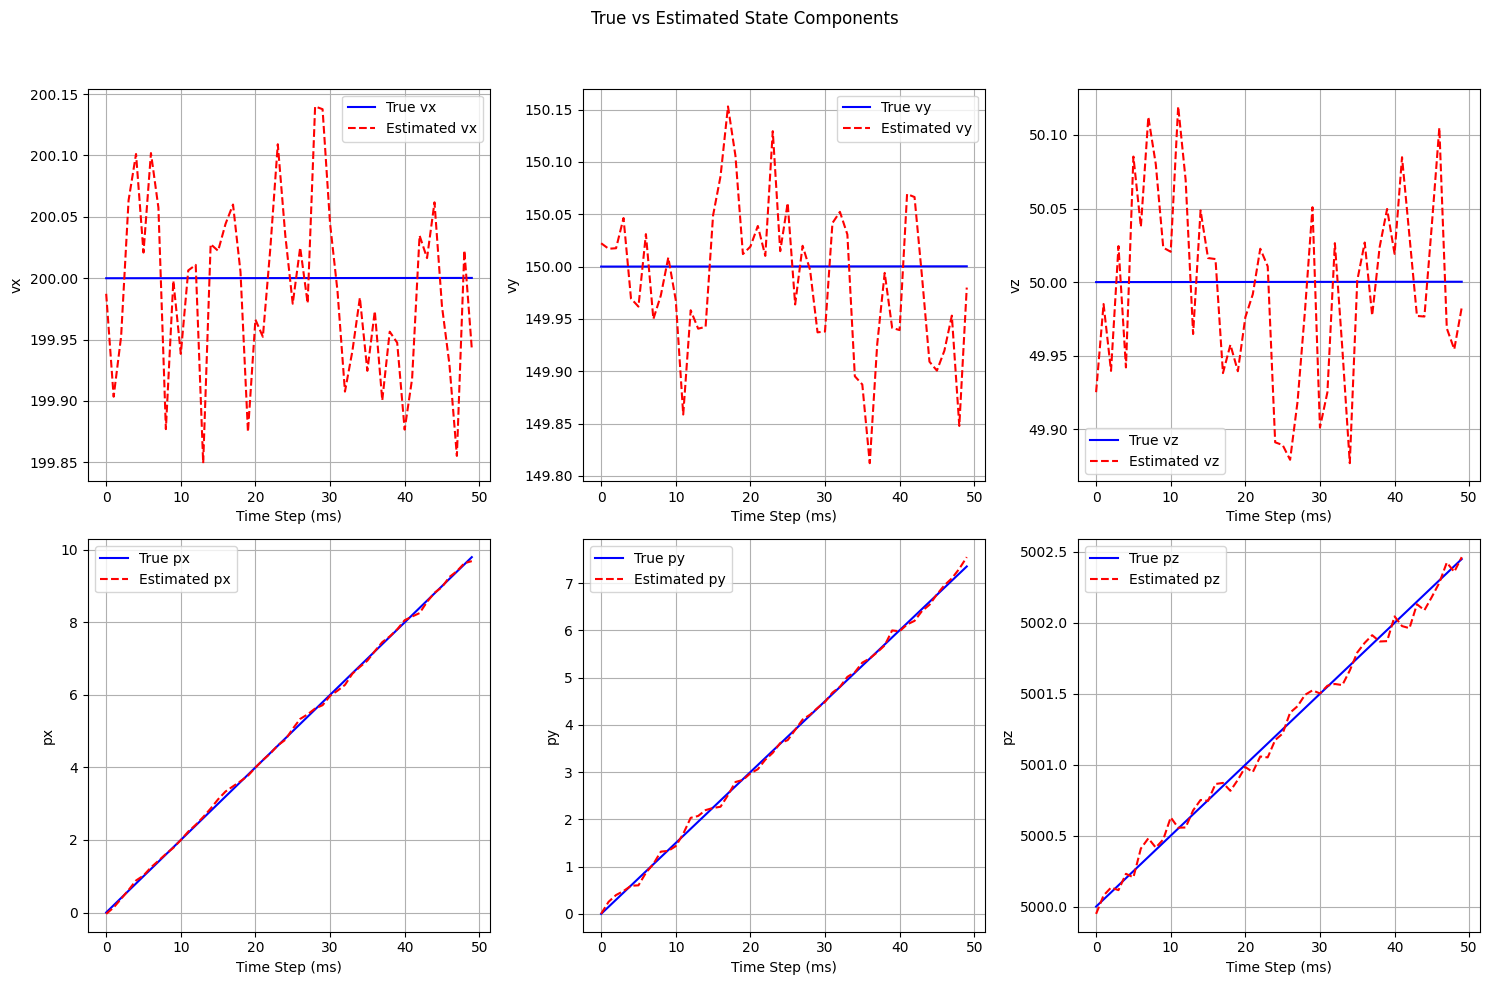

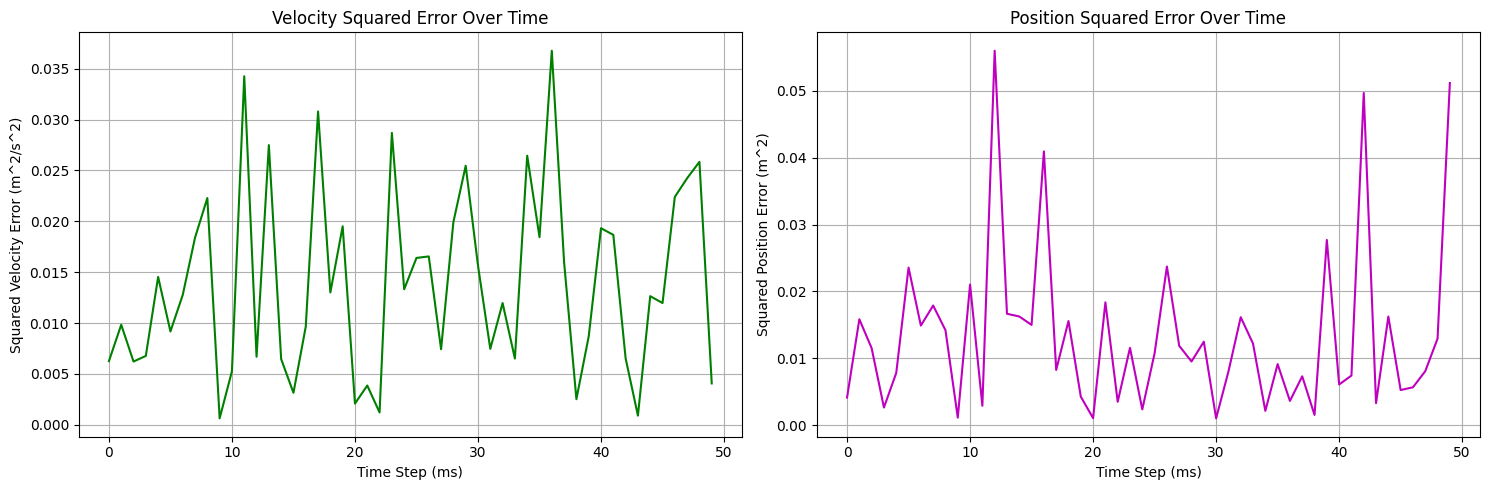

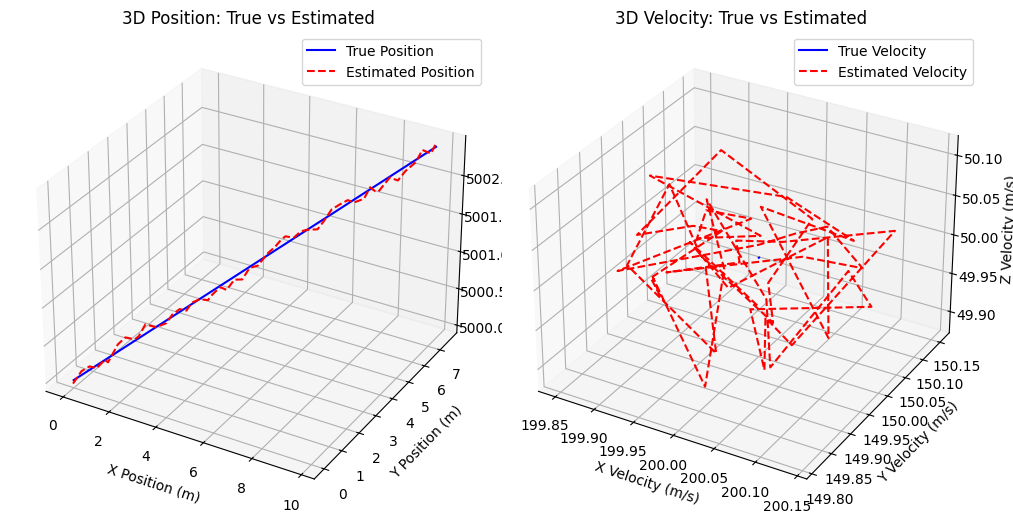

In [1]:
@dataclass
class Vector3D:
    x: float
    y: float
    z: float

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def norm(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

class MissileTracker:
    def __init__(self, measurement_interval):
        self.dt = 0.001
        self.T = measurement_interval
        self.x = np.zeros(6)
        self.F = np.eye(6)
        self.F[3:, :3] = np.eye(3) * self.dt
        self.B = np.zeros((6, 3))
        self.B[:3, :] = np.eye(3) * self.dt
        self.B[3:, :] = np.eye(3) * 0.5 * self.dt**2
        self.H = np.eye(6)
        self.P = np.eye(6) * 0.1
        self.Q = np.eye(6) * 0.01
        self.R = np.eye(6)

    def predict(self, acceleration):
        u = np.array([acceleration.x, acceleration.y, acceleration.z])
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, measurement):
        y = measurement - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(6) - K @ self.H) @ self.P

    def get_position(self):
        return Vector3D(self.x[3], self.x[4], self.x[5])

    def get_velocity(self):
        return Vector3D(self.x[0], self.x[1], self.x[2])


def simulate_target(initial_state, steps, acceleration):
    state = initial_state.copy()
    states = [state.copy()]

    for _ in range(steps):
        state[:3] += np.array([acceleration.x, acceleration.y, acceleration.z]) * 0.001
        state[3:] += state[:3] * 0.001
        states.append(state.copy())

    return np.array(states)

def main():
    TOTAL_STEPS = 50
    MEASUREMENT_INTERVAL = 1
    NOISE_STD = 0.1

    tracker = MissileTracker(MEASUREMENT_INTERVAL)

    initial_state = np.array([
        200.0, 150.0, 50.0,
        0.0, 0.0, 5000.0
    ])

    constant_acceleration = Vector3D(0.005, 0.005, 0.005)

    true_states = simulate_target(initial_state, TOTAL_STEPS, constant_acceleration)

    tracker.x = initial_state
    tracker.R = np.eye(6) * NOISE_STD**2

    estimated_positions = []
    estimated_velocities = []
    position_errors = []
    velocity_errors = []

    for step in range(TOTAL_STEPS):
        true_state = true_states[step]
        tracker.predict(constant_acceleration)
        if step % MEASUREMENT_INTERVAL == 0:
            measurement = true_state + np.random.normal(0, NOISE_STD, 6)
            tracker.update(measurement)

        est_pos = tracker.get_position()
        est_vel = tracker.get_velocity()
        true_pos = Vector3D(true_state[3], true_state[4], true_state[5])
        true_vel = Vector3D(true_state[0], true_state[1], true_state[2])

        pos_error = (est_pos - true_pos).norm()
        vel_error = (est_vel - true_vel).norm()

        estimated_positions.append([est_pos.x, est_pos.y, est_pos.z])
        estimated_velocities.append([est_vel.x, est_vel.y, est_vel.z])
        position_errors.append(pos_error**2)
        velocity_errors.append(vel_error**2)

    print(f"\nAverage Position Error: {np.mean(position_errors):.2f} meters")
    print(f"Max Position Error: {np.max(position_errors):.2f} meters")

    plot_results(true_states[:TOTAL_STEPS], np.array(estimated_positions),
                 np.array(estimated_velocities), position_errors, velocity_errors)

def plot_results(true_states, estimated_positions, estimated_velocities, pos_errors, vel_errors):
    """Visualize tracking results with each state component and squared errors."""
    time_steps = np.arange(len(pos_errors))
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i, label in enumerate(['vx', 'vy', 'vz', 'px', 'py', 'pz']):
        true_values = true_states[:, i]
        est_values = estimated_velocities[:, i] if i < 3 else estimated_positions[:, i - 3]
        ax = axs[i // 3, i % 3]
        ax.plot(time_steps, true_values, 'b-', label=f'True {label}')
        ax.plot(time_steps, est_values, 'r--', label=f'Estimated {label}')
        ax.set_xlabel('Time Step (ms)')
        ax.set_ylabel(f'{label}')
        ax.legend()
        ax.grid(True)

    fig.suptitle('True vs Estimated State Components')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(time_steps, vel_errors, 'g-')
    axs[0].set_xlabel('Time Step (ms)')
    axs[0].set_ylabel('Squared Velocity Error (m^2/s^2)')
    axs[0].set_title('Velocity Squared Error Over Time')
    axs[0].grid(True)

    axs[1].plot(time_steps, pos_errors, 'm-')
    axs[1].set_xlabel('Time Step (ms)')
    axs[1].set_ylabel('Squared Position Error (m^2)')
    axs[1].set_title('Position Squared Error Over Time')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))


    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(true_states[:, 3], true_states[:, 4], true_states[:, 5], label='True Position', color='b')
    ax1.plot(estimated_positions[:, 0], estimated_positions[:, 1], estimated_positions[:, 2], label='Estimated Position', color='r', linestyle='--')
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.set_zlabel('Z Position (m)')
    ax1.set_title('3D Position: True vs Estimated')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True Velocity', color='b')
    ax2.plot(estimated_velocities[:, 0], estimated_velocities[:, 1], estimated_velocities[:, 2], label='Estimated Velocity', color='r', linestyle='--')
    ax2.set_xlabel('X Velocity (m/s)')
    ax2.set_ylabel('Y Velocity (m/s)')
    ax2.set_zlabel('Z Velocity (m/s)')
    ax2.set_title('3D Velocity: True vs Estimated')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Running simulation with noise standard deviation: 0.1

Average Position Error with noise 0.1: 0.01 meters
Max Position Error with noise 0.1: 0.04 meters


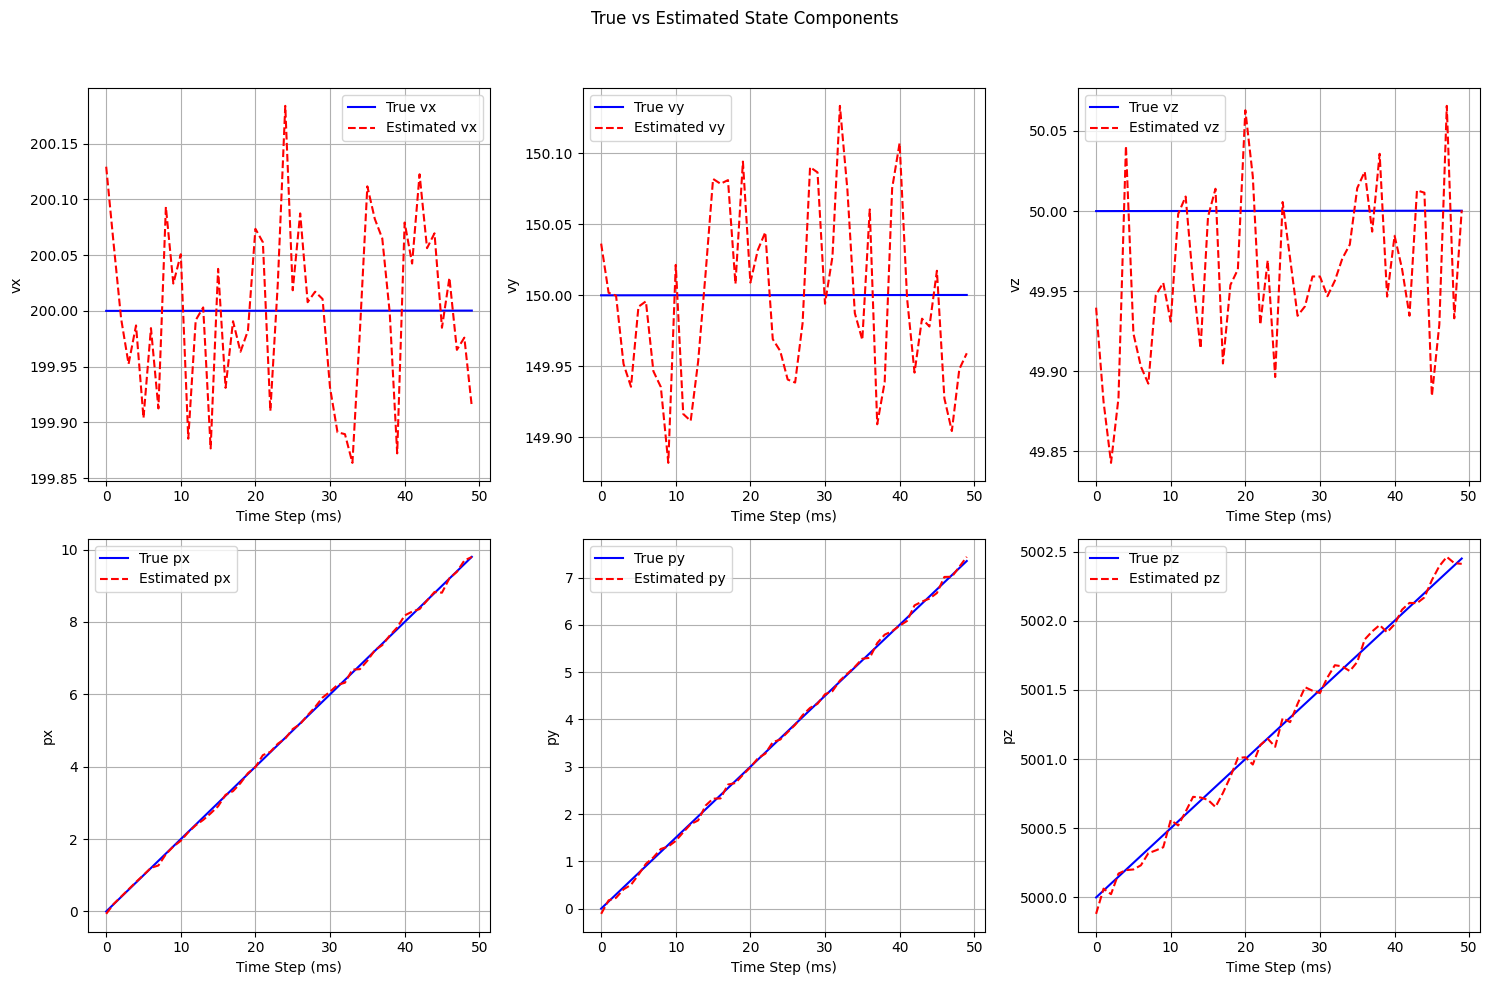

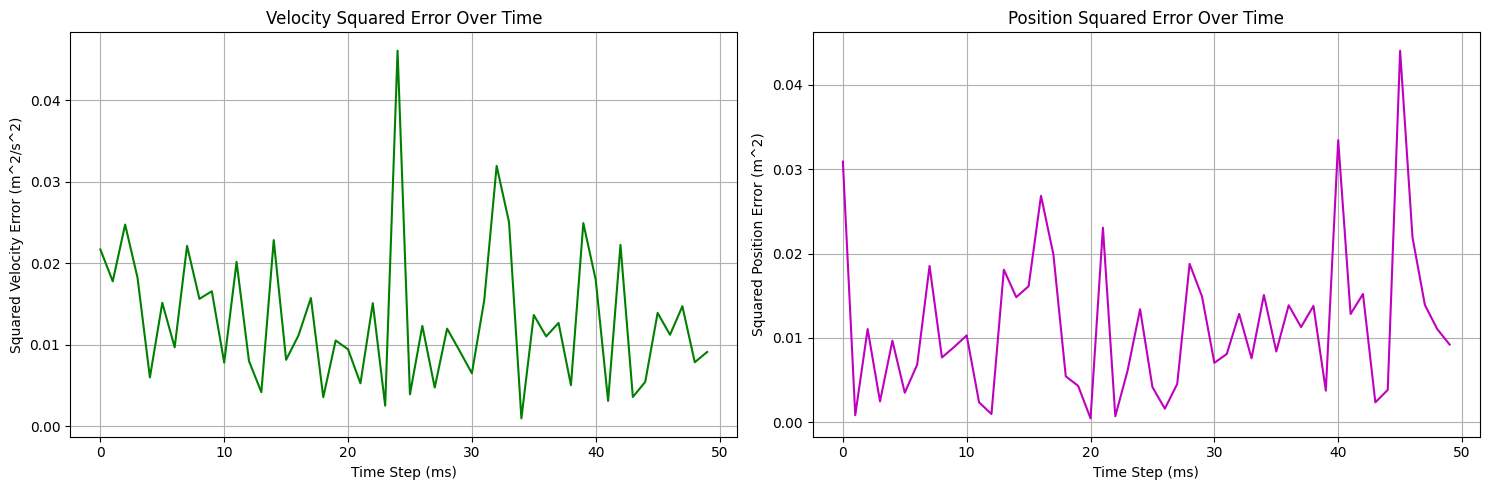

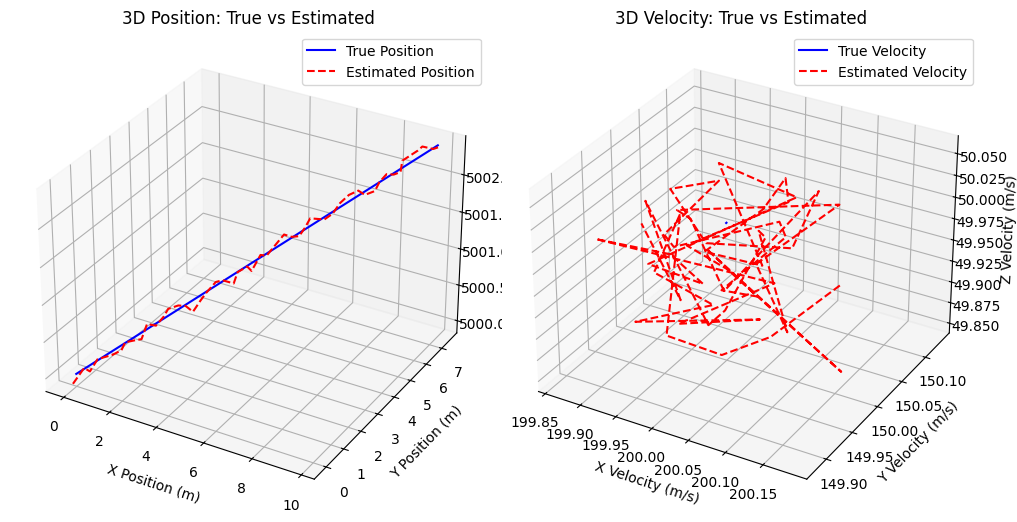

Running simulation with noise standard deviation: 0.5

Average Position Error with noise 0.5: 0.07 meters
Max Position Error with noise 0.5: 0.30 meters


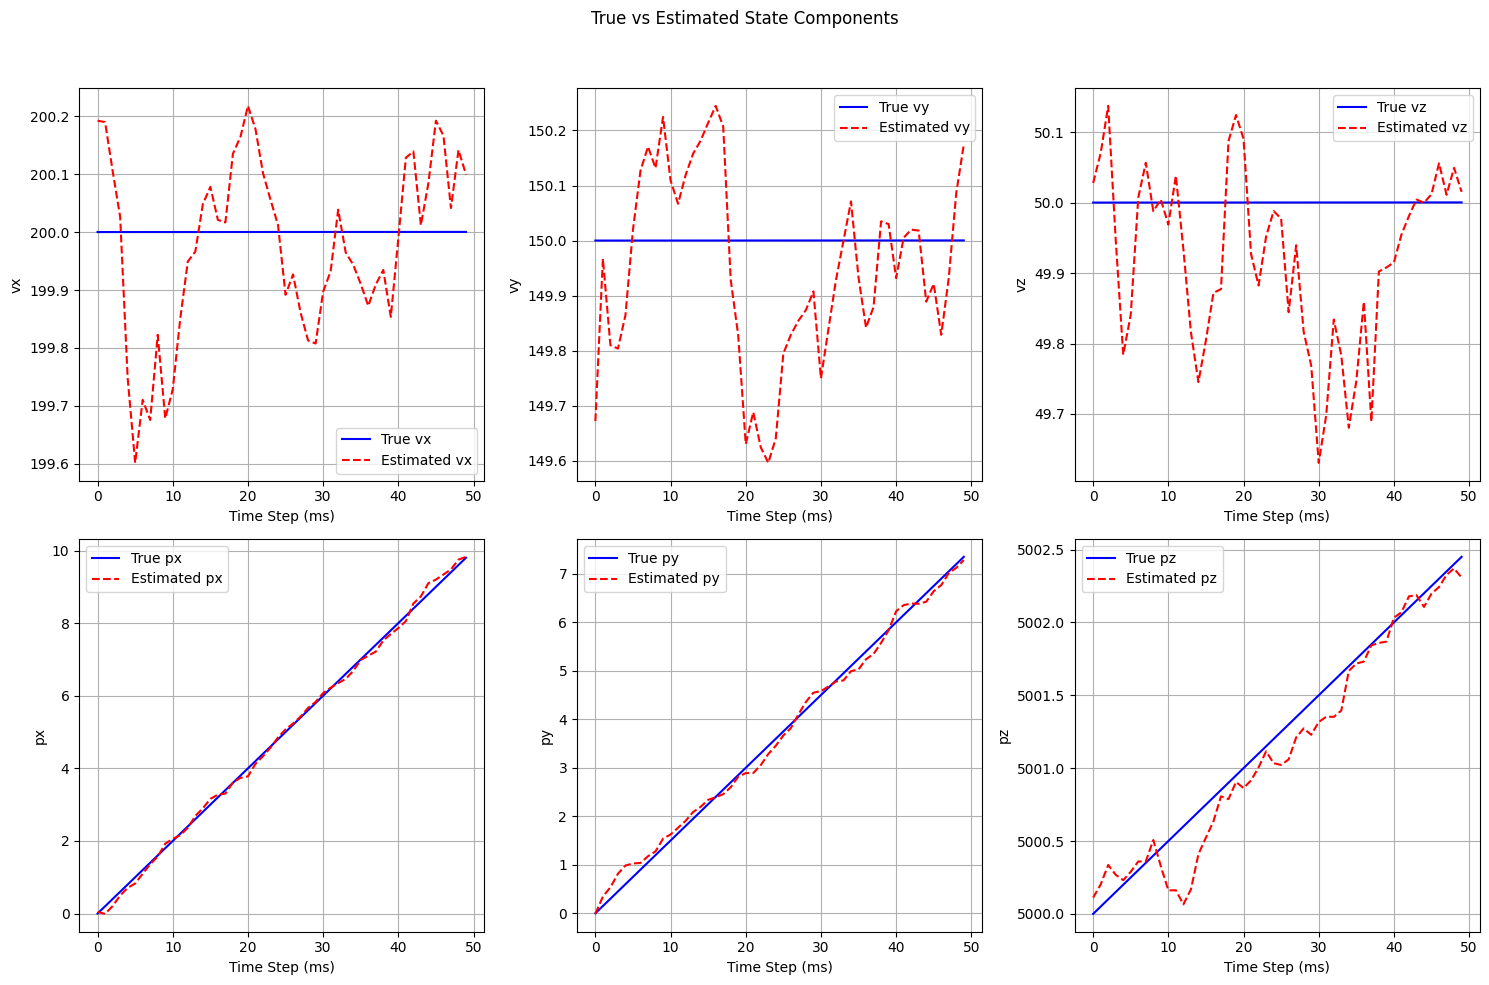

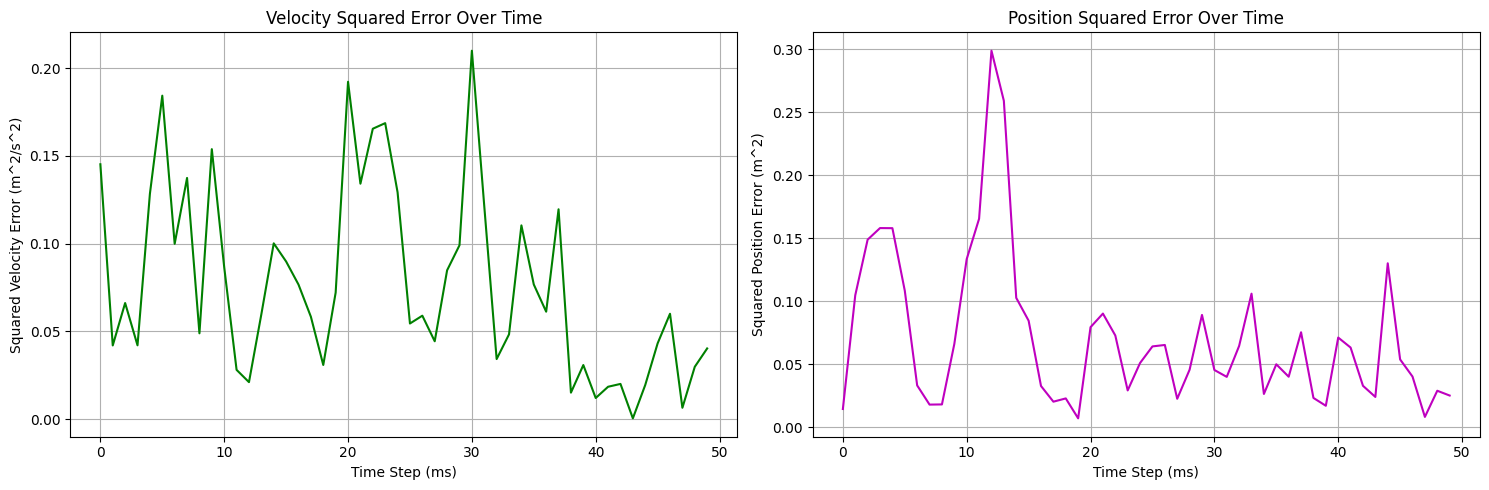

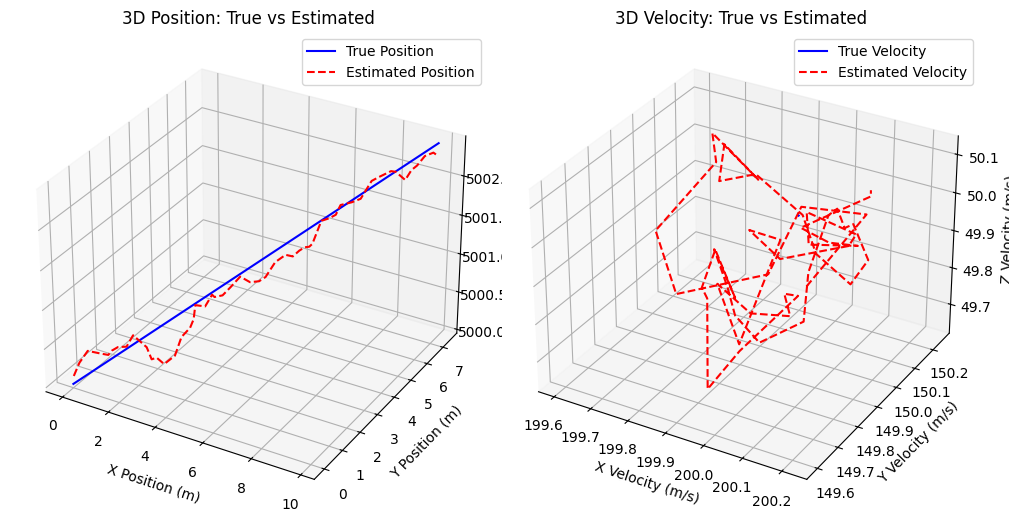

Running simulation with noise standard deviation: 1.0

Average Position Error with noise 1.0: 0.11 meters
Max Position Error with noise 1.0: 0.31 meters


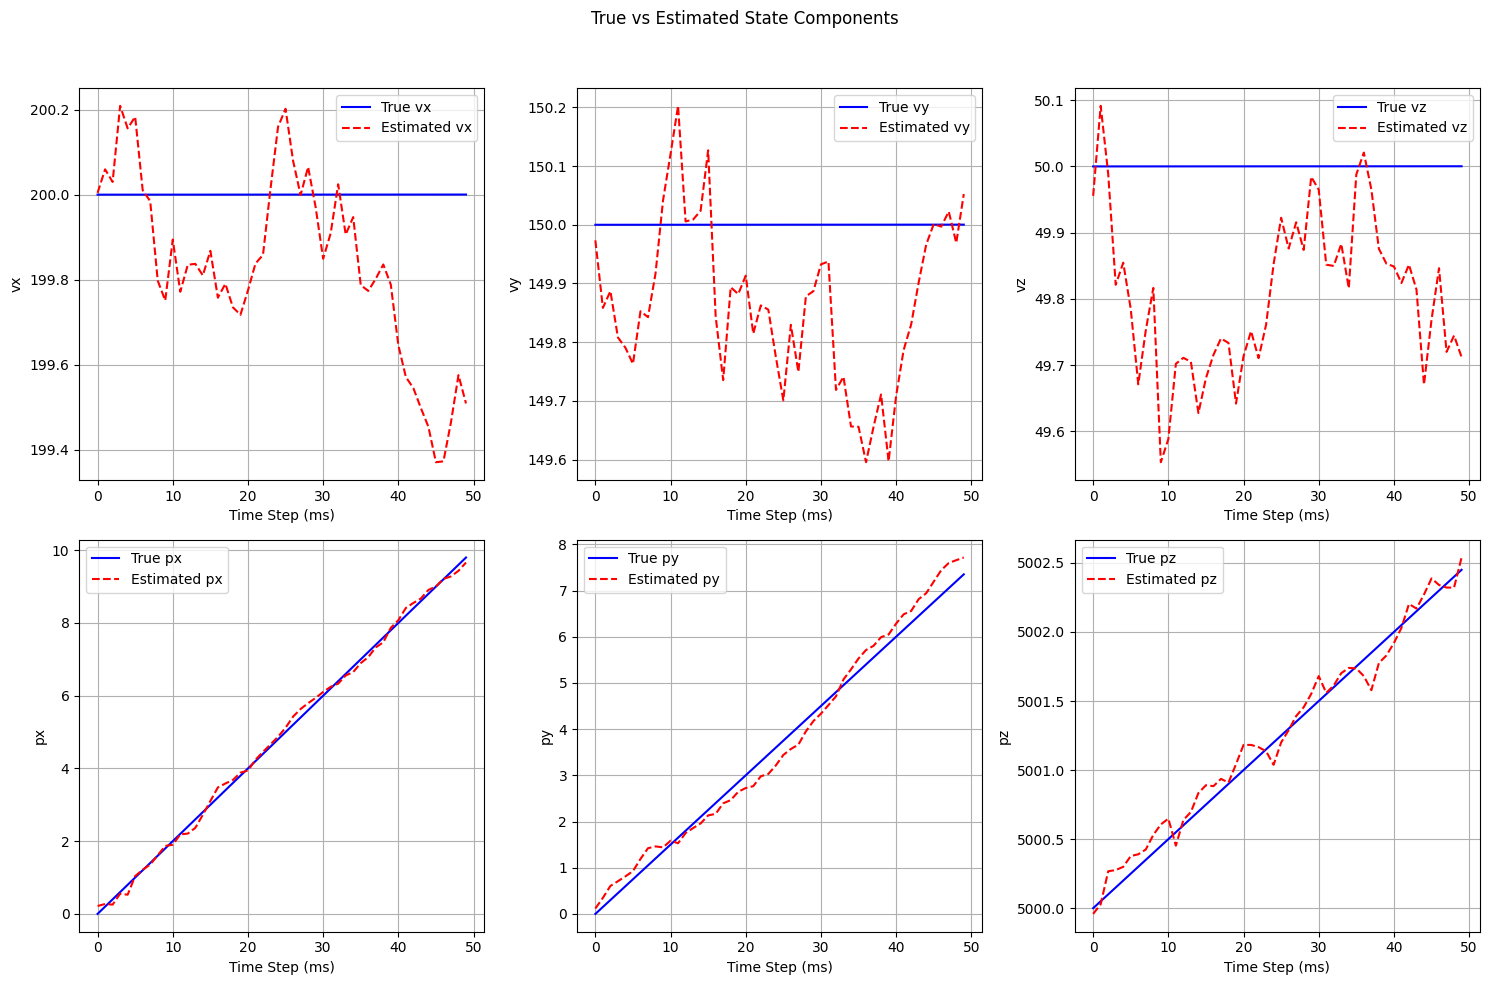

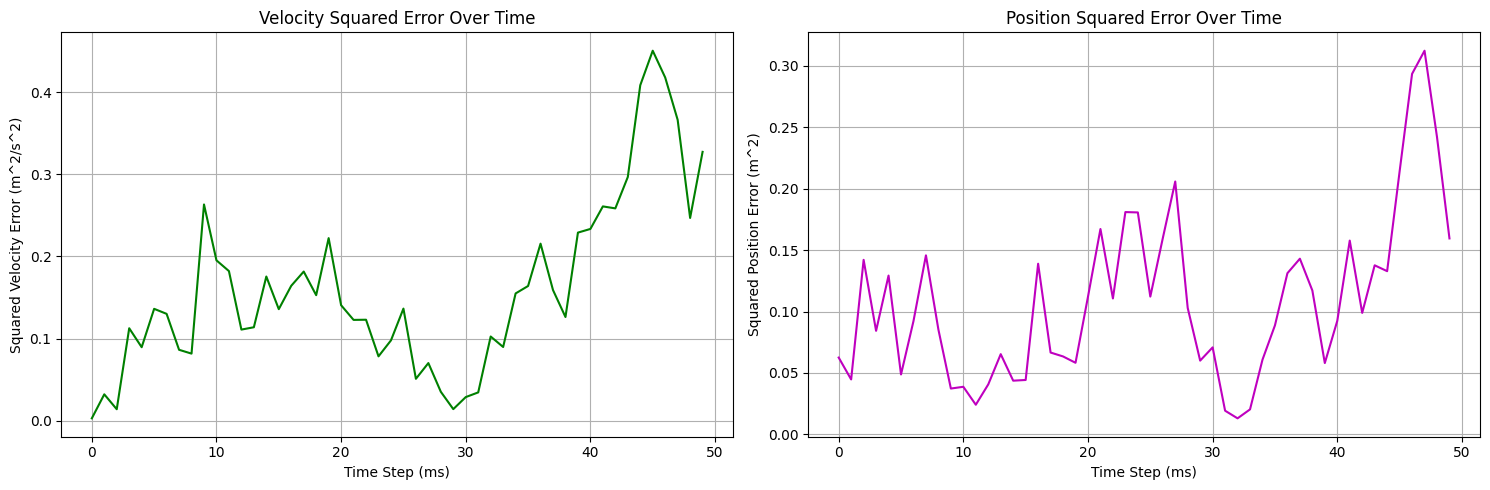

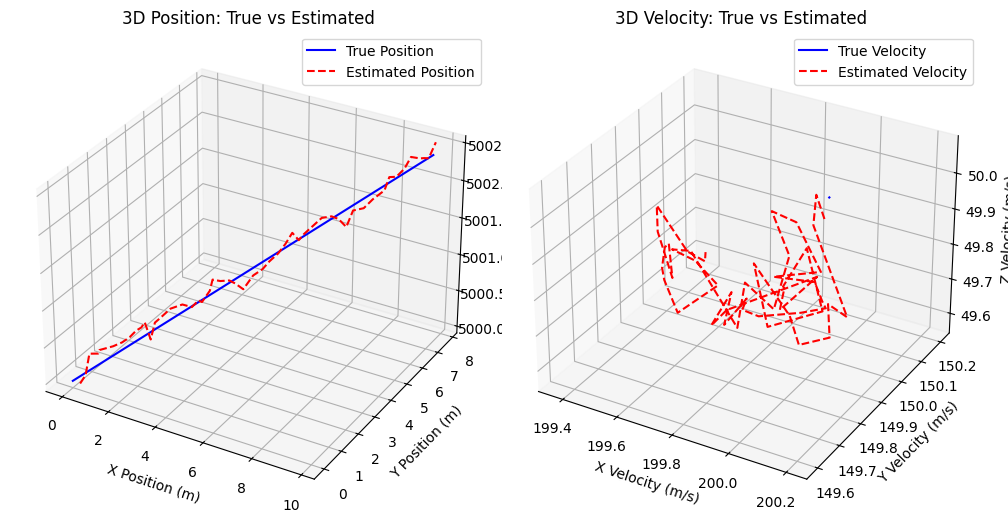

In [33]:
def main():
    TOTAL_STEPS = 50
    MEASUREMENT_INTERVAL = 1
    NOISE_LEVELS = [0.1, 0.5, 1.0]

    initial_state = np.array([
        200.0, 150.0, 50.0,
        0.0, 0.0, 5000.0
    ])

    constant_acceleration = Vector3D(0.005, 0.005, 0.005)

    true_states = simulate_target(initial_state, TOTAL_STEPS, constant_acceleration)

    for noise_std in NOISE_LEVELS:
        print(f"Running simulation with noise standard deviation: {noise_std}")

        tracker = MissileTracker(MEASUREMENT_INTERVAL)
        tracker.x = initial_state
        tracker.R = np.eye(6) * noise_std**2

        estimated_positions = []
        estimated_velocities = []
        position_errors = []
        velocity_errors = []

        for step in range(TOTAL_STEPS):
            true_state = true_states[step]
            tracker.predict(constant_acceleration)
            if step % MEASUREMENT_INTERVAL == 0:
                measurement = true_state + np.random.normal(0, noise_std, 6)
                tracker.update(measurement)

            est_pos = tracker.get_position()
            est_vel = tracker.get_velocity()
            true_pos = Vector3D(true_state[3], true_state[4], true_state[5])
            true_vel = Vector3D(true_state[0], true_state[1], true_state[2])

            pos_error = (est_pos - true_pos).norm()
            vel_error = (est_vel - true_vel).norm()

            estimated_positions.append([est_pos.x, est_pos.y, est_pos.z])
            estimated_velocities.append([est_vel.x, est_vel.y, est_vel.z])
            position_errors.append(pos_error**2)
            velocity_errors.append(vel_error**2)

        print(f"\nAverage Position Error with noise {noise_std}: {np.mean(position_errors):.2f} meters")
        print(f"Max Position Error with noise {noise_std}: {np.max(position_errors):.2f} meters")

        plot_results(true_states[:TOTAL_STEPS], np.array(estimated_positions),
                     np.array(estimated_velocities), position_errors, velocity_errors)

if __name__ == "__main__":
    main()


Experiment with varying Acceleration levels

Running simulation with constant acceleration: 0.005

Average Position Error with acceleration 0.005: 0.01 meters
Max Position Error with acceleration 0.005: 0.04 meters


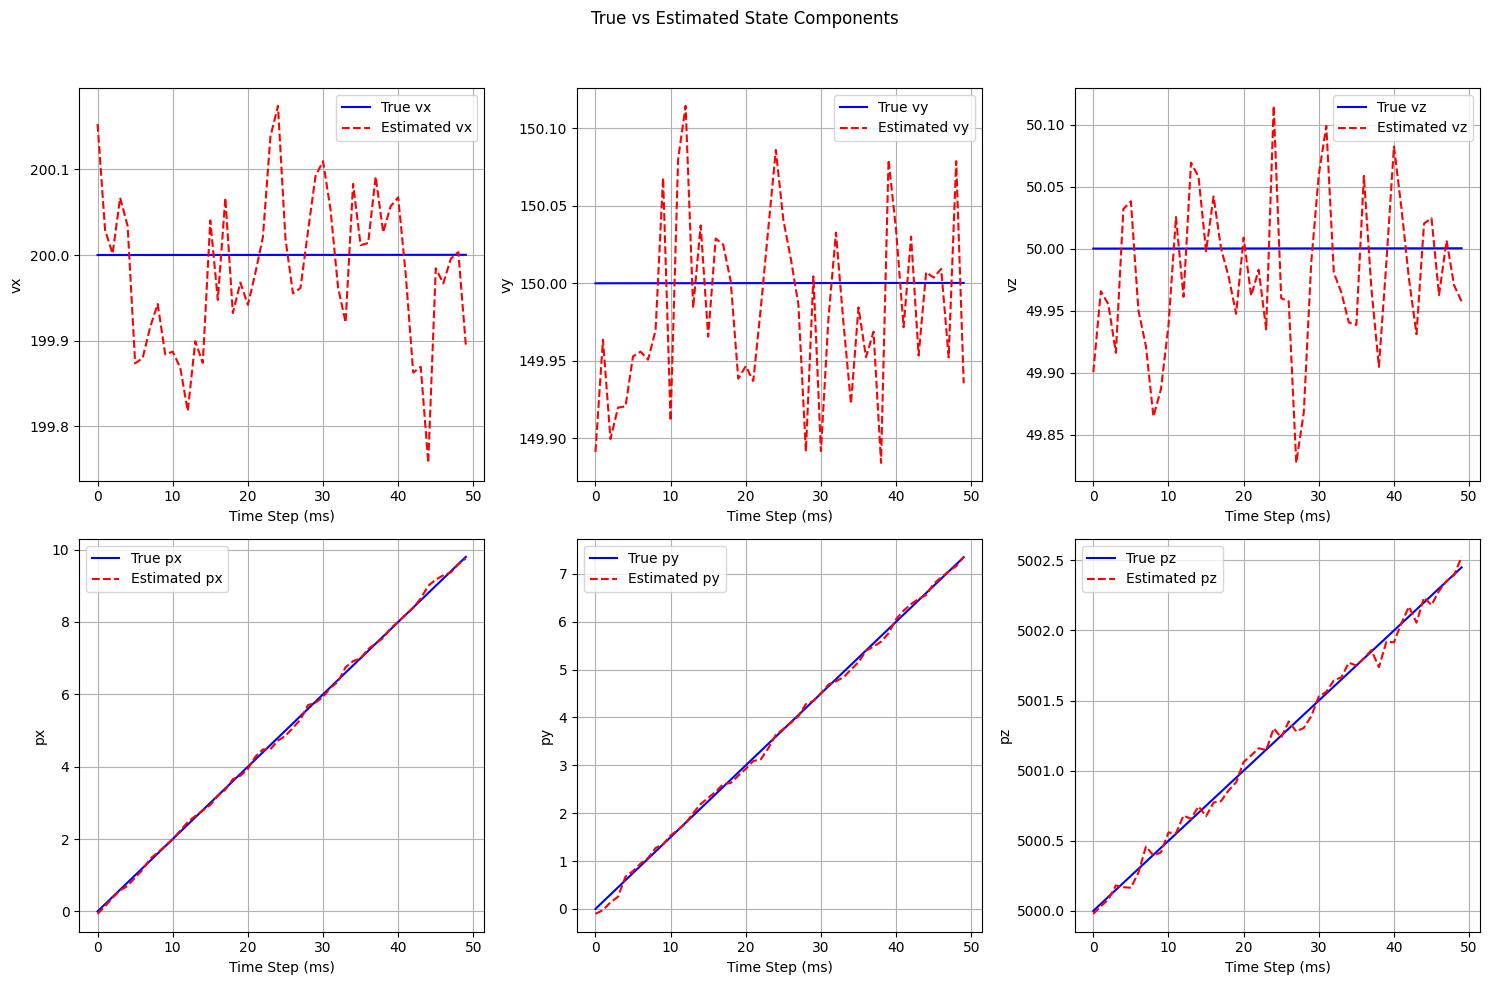

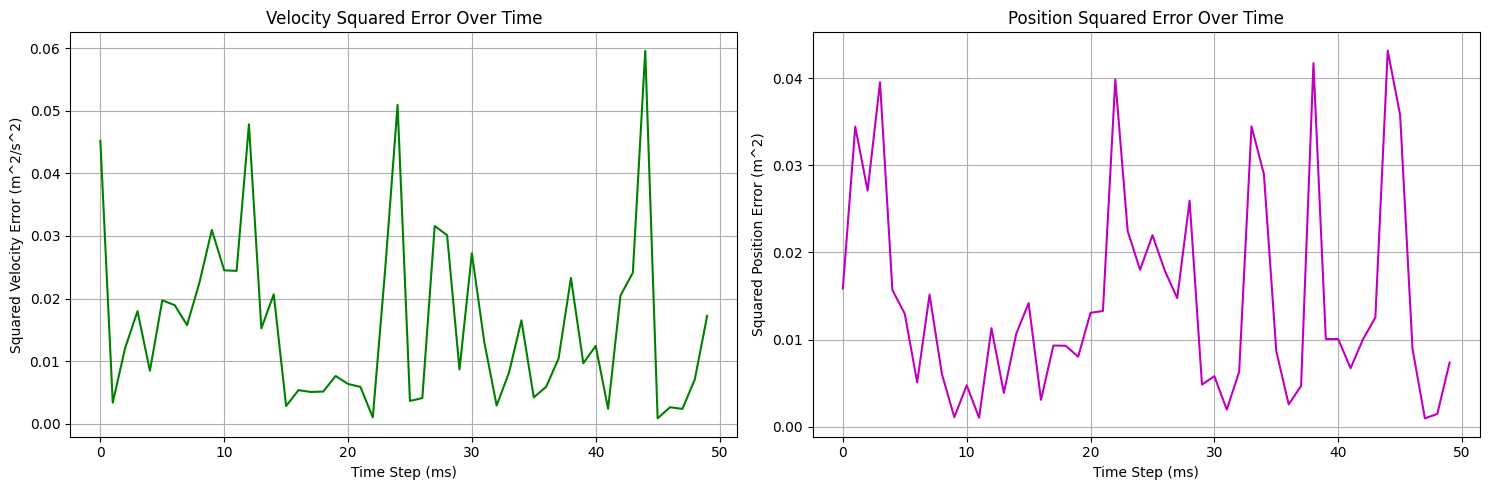

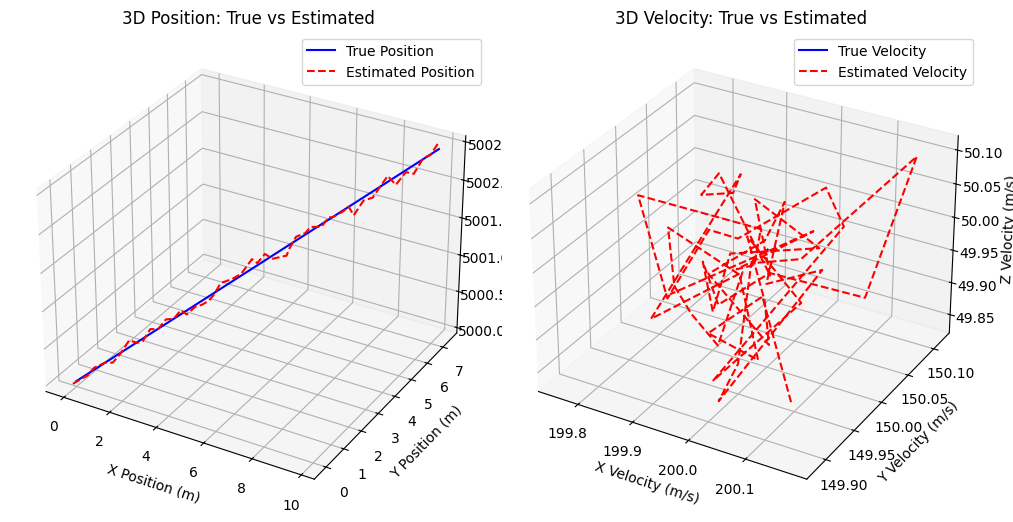

Running simulation with constant acceleration: 0.01

Average Position Error with acceleration 0.01: 0.01 meters
Max Position Error with acceleration 0.01: 0.04 meters


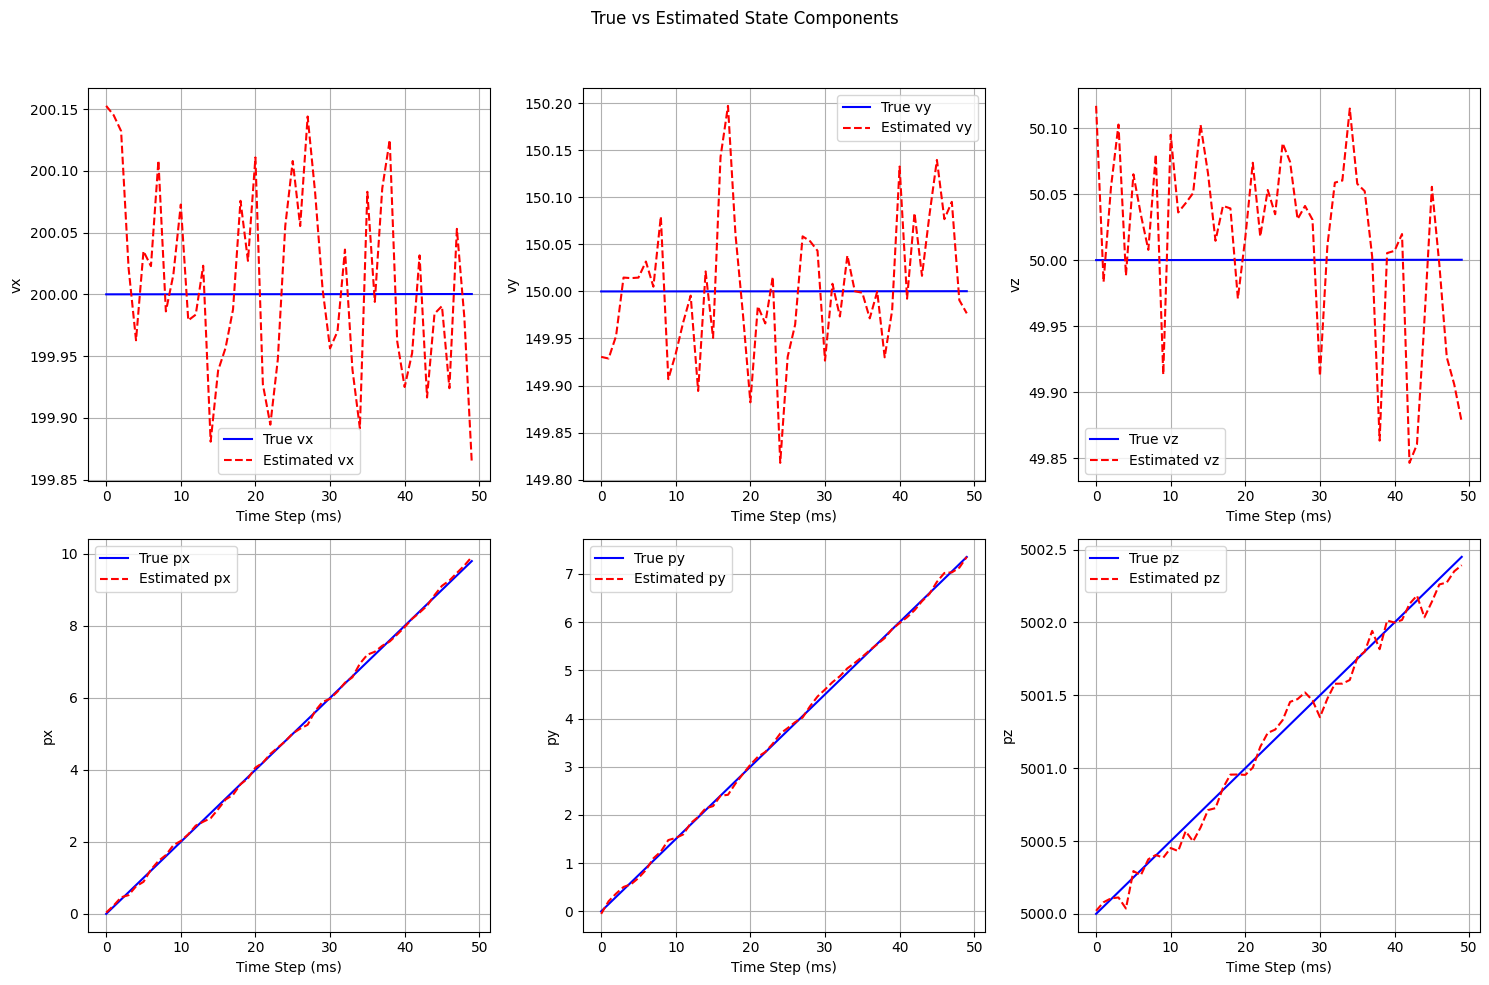

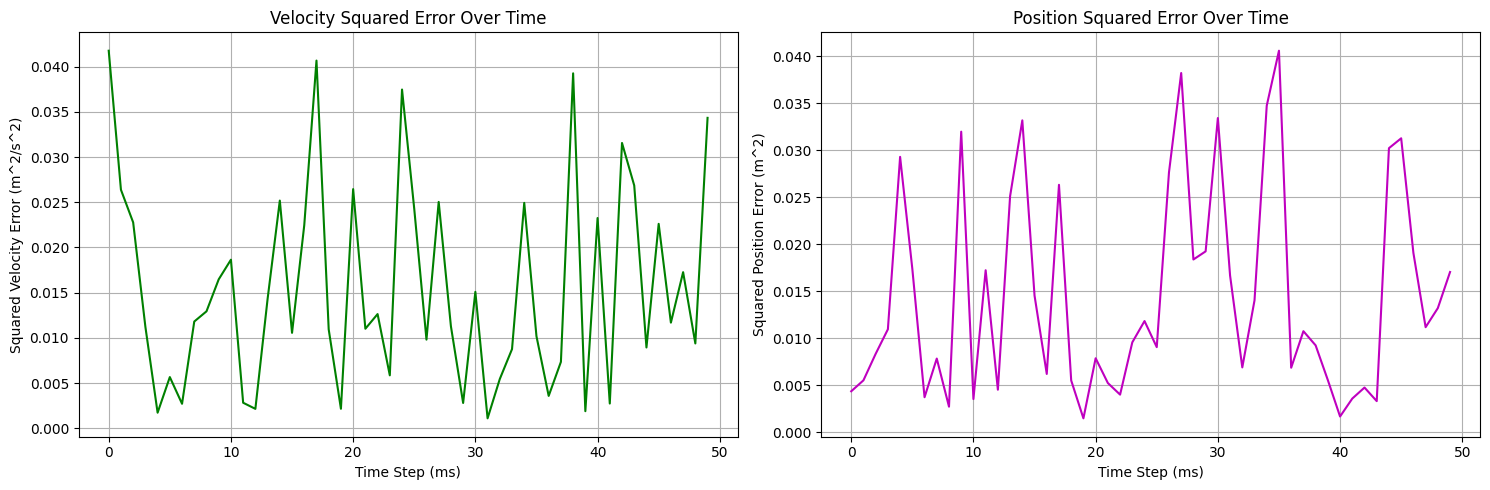

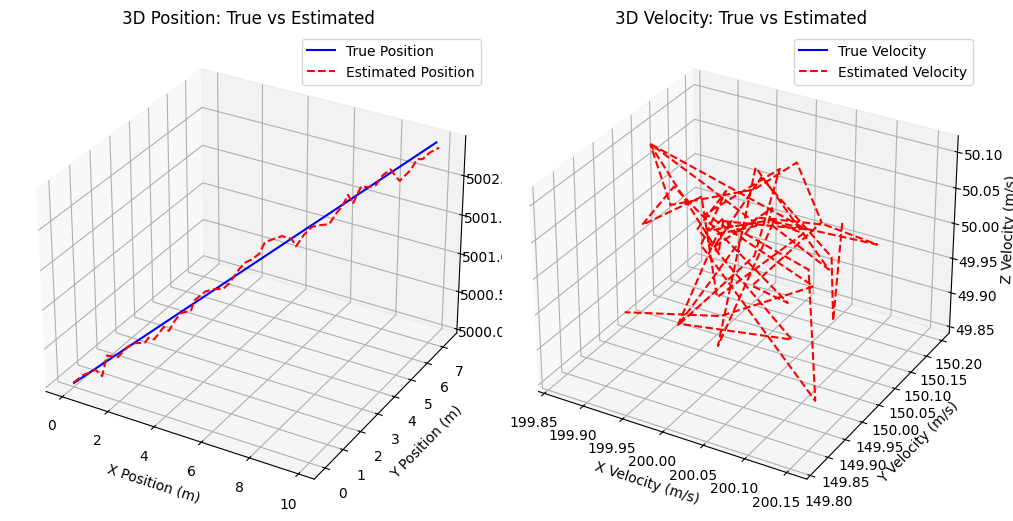

Running simulation with constant acceleration: 0.02

Average Position Error with acceleration 0.02: 0.01 meters
Max Position Error with acceleration 0.02: 0.07 meters


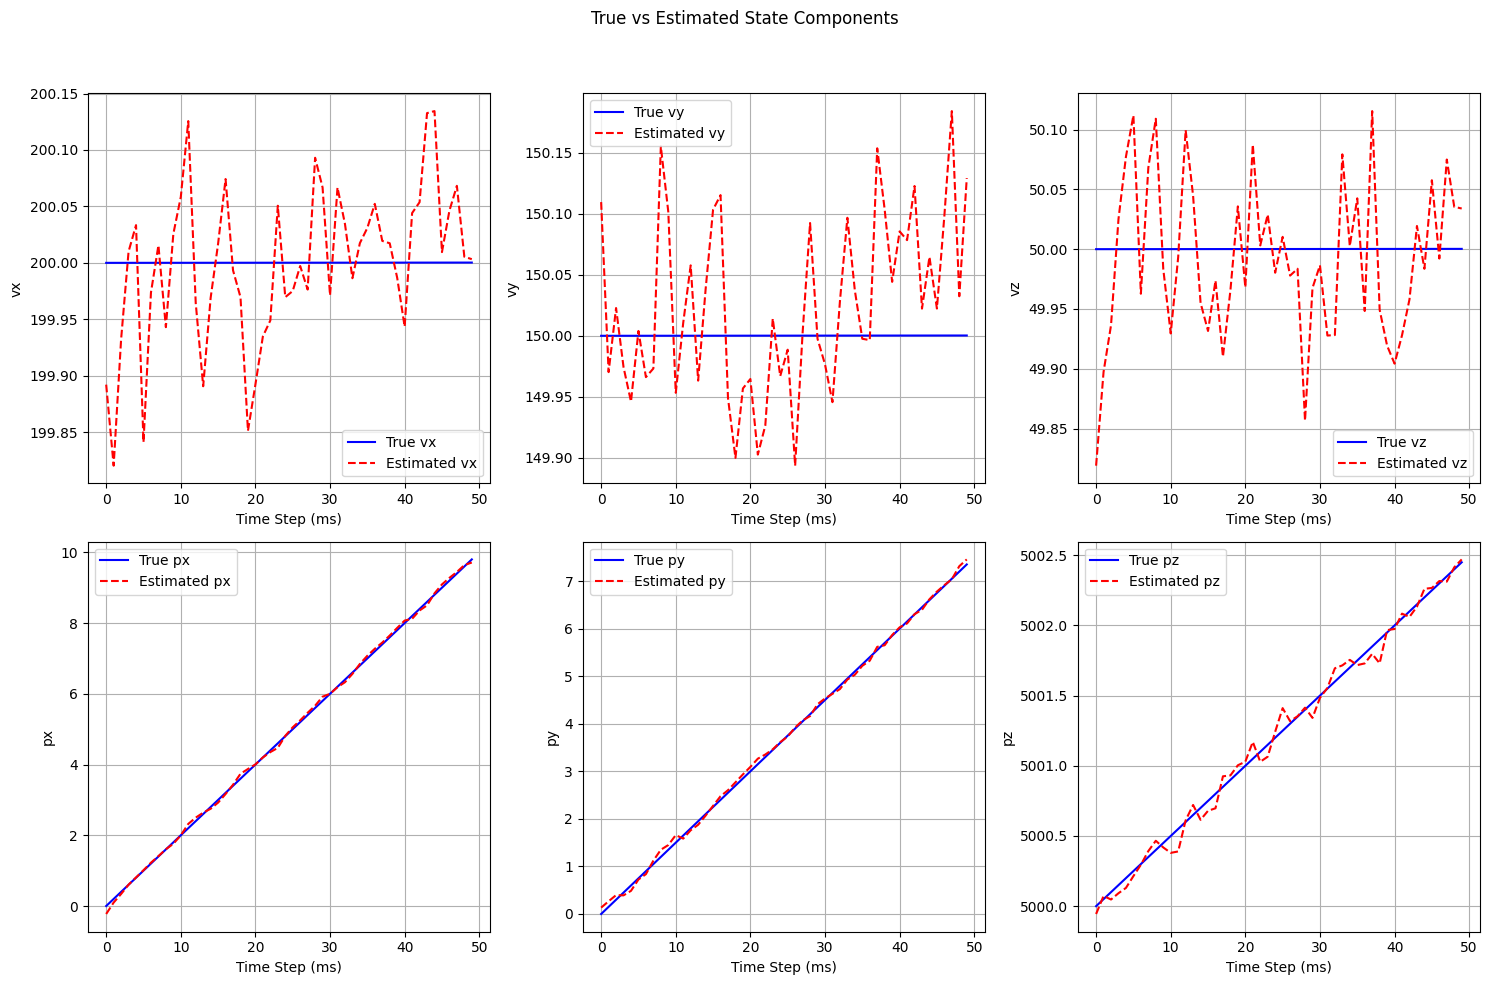

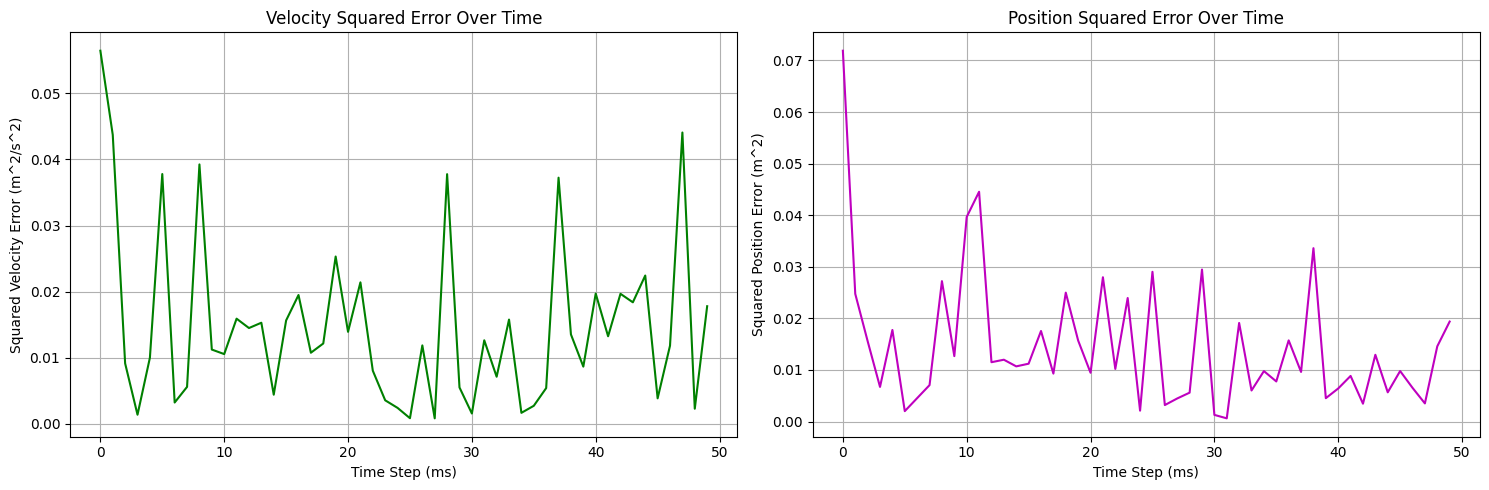

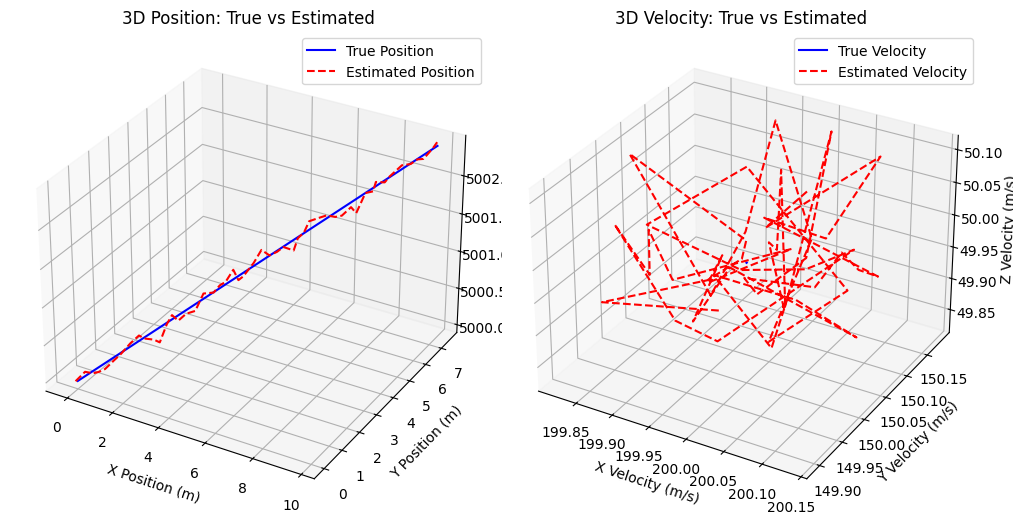

In [3]:
def main():
    TOTAL_STEPS = 50
    MEASUREMENT_INTERVAL = 1
    ACCELERATION_LEVELS = [0.005, 0.01, 0.02]
    TIME_DEPENDENT_ACCELERATION = [True, False, True]

    initial_state = np.array([
        200.0, 150.0, 50.0,
        0.0, 0.0, 5000.0
    ])

    constant_acceleration = Vector3D(0.005, 0.005, 0.005)

    true_states = simulate_target(initial_state, TOTAL_STEPS, constant_acceleration)
    i = 0

    for accel in ACCELERATION_LEVELS:
        print(f"Running simulation with constant acceleration: {accel}")

        tracker = MissileTracker(MEASUREMENT_INTERVAL)
        tracker.x = initial_state
        tracker.R = np.eye(6) * 0.1**2

        estimated_positions = []
        estimated_velocities = []
        position_errors = []
        velocity_errors = []

        for step in range(TOTAL_STEPS):
            true_state = true_states[step]

            if TIME_DEPENDENT_ACCELERATION[i]:
                time_factor = (step + 1) / TOTAL_STEPS
                acceleration = Vector3D(accel * time_factor, accel * time_factor, accel * time_factor)
            else:
                acceleration = Vector3D(accel, accel, accel)

            tracker.predict(acceleration)

            if step % MEASUREMENT_INTERVAL == 0:
                measurement = true_state + np.random.normal(0, 0.1, 6)
                tracker.update(measurement)

            ++i

            est_pos = tracker.get_position()
            est_vel = tracker.get_velocity()
            true_pos = Vector3D(true_state[3], true_state[4], true_state[5])
            true_vel = Vector3D(true_state[0], true_state[1], true_state[2])

            pos_error = (est_pos - true_pos).norm()
            vel_error = (est_vel - true_vel).norm()

            estimated_positions.append([est_pos.x, est_pos.y, est_pos.z])
            estimated_velocities.append([est_vel.x, est_vel.y, est_vel.z])
            position_errors.append(pos_error**2)
            velocity_errors.append(vel_error**2)

        print(f"\nAverage Position Error with acceleration {accel}: {np.mean(position_errors):.2f} meters")
        print(f"Max Position Error with acceleration {accel}: {np.max(position_errors):.2f} meters")

        plot_results(true_states[:TOTAL_STEPS], np.array(estimated_positions),
                     np.array(estimated_velocities), position_errors, velocity_errors)

if __name__ == "__main__":
    main()


Experiment with different values of T(the measurement interval)

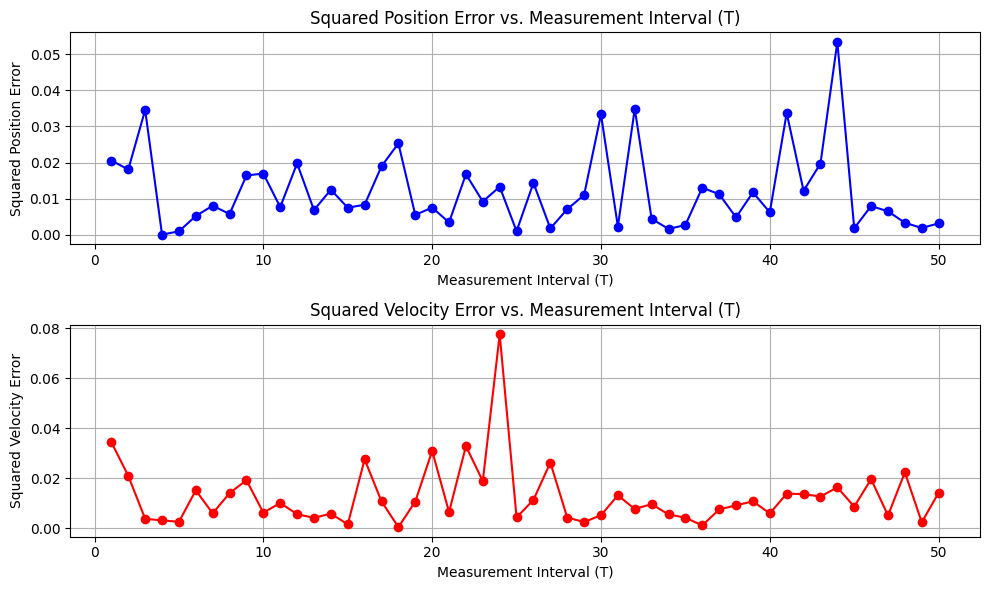

In [14]:
def main():
    MAX_T = 50
    MEASUREMENT_INTERVALS = range(1, MAX_T + 1, 1)

    initial_state = np.array([
        200.0, 150.0, 50.0,
        0.0, 0.0, 5000.0
    ])

    true_states = simulate_target(initial_state, MAX_T, Vector3D(0.005, 0.005, 0.005))

    squared_position_errors = []
    squared_velocity_errors = []

    for MEASUREMENT_INTERVAL in MEASUREMENT_INTERVALS:
        position_errors = []
        velocity_errors = []

        tracker = MissileTracker(MEASUREMENT_INTERVAL)
        tracker.x = initial_state
        tracker.R = np.eye(6) * 0.1**2

        for step in range(MEASUREMENT_INTERVAL):
            acceleration = Vector3D(0.05, 0.05, 0.5)

            tracker.predict(acceleration)

            true_state = true_states[step]
            measurement = true_state + np.random.normal(0, 0.1, 6)
            tracker.update(measurement)

            est_pos = tracker.get_position()
            est_vel = tracker.get_velocity()

            true_pos = Vector3D(true_state[3], true_state[4], true_state[5])
            true_vel = Vector3D(true_state[0], true_state[1], true_state[2])

            pos_error = (est_pos - true_pos).norm()
            vel_error = (est_vel - true_vel).norm()

            position_errors.append(pos_error)
            velocity_errors.append(vel_error)

        squared_position_errors.append(position_errors[-1]**2)
        squared_velocity_errors.append(velocity_errors[-1]**2)

    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(MEASUREMENT_INTERVALS, squared_position_errors, marker='o', color='b')
    plt.title('Squared Position Error vs. Measurement Interval (T)')
    plt.xlabel('Measurement Interval (T)')
    plt.ylabel('Squared Position Error')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(MEASUREMENT_INTERVALS, squared_velocity_errors, marker='o', color='r')
    plt.title('Squared Velocity Error vs. Measurement Interval (T)')
    plt.xlabel('Measurement Interval (T)')
    plt.ylabel('Squared Velocity Error')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()